# EC500 - Group 6 - Denoising CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [1]:
# !pip install pynrrd
# !pip install SimpleITK
# !python -c "import monai" || pip install -q "monai"
# !python -c "import matplotlib" || pip install -q matplotlib
# %matplotlib inline

In [2]:
# !pip install monai --upgrade

In [3]:
# !pip install patchify

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import ndimage
import tempfile
import shutil
import glob

In [5]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Activations,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Compose,
    AsChannelLastd,
    CropForegroundd,
    ScaleIntensityd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    RandSpatialCropSamplesd,
    RandSpatialCropSamples,
    RandSpatialCropd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    RandRotated,
    RandFlipd,
    RandZoomd,
    RandScaleIntensityd, 
    RandShiftIntensityd,
    #AddChannel,
    ToTensord,
    NormalizeIntensityd
)
from monai.handlers.utils import from_engine 
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference 
from monai.inferers import SlidingWindowInferer
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from patchify import patchify
import math


In [6]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [7]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Section-2: Initial data inspection and experimentation

In [8]:
# initializing directory
data_dir = "./scans"

In [9]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
size_check = all(size == sizes[0] for size in sizes)
shape_check = all(shape == shapes[0] for shape in shapes)

if dims_check and size_check and shape_check:
    print('Dimensions, shapes and sizes are uniform')
else:
    print('Dimensions, shapes and sizes are NOT uniform')
    
print('The total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes are NOT uniform
The total number of images in the dataset is 30


In [10]:
list(shapes)

[(512, 512, 610),
 (512, 512, 560),
 (512, 512, 533),
 (512, 512, 823),
 (512, 512, 610),
 (512, 512, 526),
 (512, 512, 533),
 (512, 512, 560),
 (512, 512, 525),
 (512, 512, 856),
 (512, 512, 525),
 (512, 512, 318),
 (512, 512, 560),
 (512, 512, 600),
 (512, 512, 585),
 (512, 512, 318),
 (512, 512, 856),
 (512, 512, 610),
 (512, 512, 526),
 (512, 512, 856),
 (512, 512, 533),
 (512, 512, 526),
 (512, 512, 525),
 (512, 512, 823),
 (512, 512, 823),
 (512, 512, 318),
 (512, 512, 585),
 (512, 512, 600),
 (512, 512, 585),
 (512, 512, 600)]

In [11]:
def convert_to_2d(img_volume, axis=1):
    return np.max(img_volume, axis=axis)

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512)),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [12]:
volume, header = nrrd.read(os.path.join(data_dir,'L506_signal.nrrd'))
volume_2d = convert_to_2d(volume)
volume_2d = trans(volume_2d)
print(volume.shape, volume_2d.squeeze().shape, volume_2d.type)

(512, 512, 526) torch.Size([512, 512]) <built-in method type of Tensor object at 0x7f19d5d137e0>


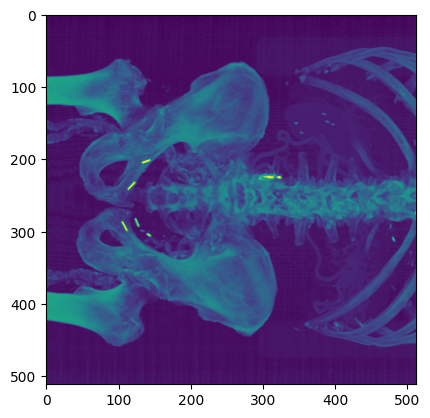

In [13]:
plt.imshow(volume_2d.squeeze())
plt.show()

In [14]:
volume_2d = volume_2d.numpy()
volume_2d.dtype

dtype('int16')

In [15]:
def patches(image):
    demo_dict = []
    image = image.squeeze()
    patches = patchify(image.numpy(), (64,64), step=64)
    #patches = patchify(image, (64,64), step=64)   
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch_img = patches[i,j,:,:]
            demo_dict.append(single_patch_img)
    return demo_dict

In [16]:
#print(type(volume_2d))
#patch1 = patches(volume_2d)

In [17]:
#len(patch1)

In [18]:
#patch1[15].shape

In [19]:
#plt.imshow(patch1[15])

## Set deterministic seed for reproducibility

In [20]:
set_determinism(seed=0)

## Section-3: Creating a custom dataset and making transforms for augmentation


In [21]:
# class CustomData(torch.utils.data.Dataset):
    
#     def __init__(self, root_dir):
#         self.root_dir = root_dir
#         self.data = []
#         image_sizes = []
        
#         for file in os.listdir(self.root_dir):
#             if file.endswith('signal.nrrd'):
#                 image_id = file.split('_')[0]
                
#                 # reading in the images
#                 signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
#                 noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
#                 std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))

#                 # converting to 2D Axial
#                 self.signal = np.max(signal_nrrd, axis=1)
#                 self.noise = np.max(noise_nrrd, axis=1)
#                 self.std = np.max(std_nrrd, axis=1)
                
#                 # converting to tensor and resizing to 512,512 for uniformity
#                 trans = transforms.Compose([transforms.ToTensor(), 
#                                            transforms.Resize((512,512))])
#                 self.signal = trans(self.signal)
#                 self.noise = trans(self.noise)
#                 self.std = trans(self.std)
                
#                 # generating input image from signal and noise
#                 k = random.uniform(0, 5)
#                 self.ct_generated = self.signal + (k * self.noise)
                
#                 # generating patches
#                 ct_patches = self.patches(self.ct_generated)
#                 std_patches = self.patches(self.std)
#                 #signal_patches = self.patches(self.signal)
                
#                 # storing the new dataset in a dictionary
#                 for i in range(len(ct_patches)):
#                     #self.data.append({'ct_generated': ct_patches[i], 'std_map': std_patches[i], 'signal': signal_patches[i]})
#                     self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
#     def patches(self, image):
#         demo_dict = []
#         image = image.squeeze()
#         patches = patchify(image.numpy(), (64, 64), step=64)

#         for i in range(patches.shape[0]):
#             for j in range(patches.shape[1]):
#                 single_patch_img = patches[i, j, :, :]
#                 demo_dict.append(single_patch_img)
#         return demo_dict

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         ct_generated = torch.from_numpy(item['ct_generated']).unsqueeze(0).float()
#         std_map = torch.from_numpy(item['std_map']).unsqueeze(0).float()
#         signal = torch.from_numpy(item['signal']).unsqueeze(0).float()
#         return {'ct_generated': ct_generated, 'std_map': std_map, 'signal':signal}

#     def plot_ct(self, idx):
#         item = self.data[idx]
#         ct_generated = item['ct_generated']
#         std_map = item['std_map']
#         signal = item['signal']
        
#         plt.figure(figsize=(5,10))
#         plt.subplot(1, 3, 1)
#         plt.imshow(signal, cmap='gray')
#         plt.title('signal Patch-0')
#         plt.axis('off')
        
#         plt.subplot(1, 3, 2)
#         plt.imshow(std_map, cmap='hot')
#         plt.title('std_map Patch-0')
#         plt.axis('off')
#         plt.show()
 
#         plt.subplot(1, 3, 3)
#         plt.imshow(ct_generated, cmap='gray')
#         plt.title('ct_generated Patch-0')
#         plt.axis('off')
#         plt.show()


In [22]:
class CustomData(torch.utils.data.Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        image_sizes = []
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0]
                
                # reading in the images
                signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
                noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
                std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))

                # converting to 2D Axial
                signal = np.max(signal_nrrd, axis=1)
                noise = np.max(noise_nrrd, axis=1)
                std = np.max(std_nrrd, axis=1)
                
                # converting to tensor and resizing to 512,512 for uniformity
                trans = transforms.Compose([transforms.ToTensor(), 
                                           transforms.Resize((512,512))])
                                           #transforms.Normalize(mean=[0.5], std=[0.5]])
                signal = trans(signal)
                noise = trans(noise)
                std = trans(std)
                
                # generating input image fromm signal and noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)
                
                # generating patches
                ct_patches = patches(ct_generated)
                std_patches = patches(std)
                #print(len(ct_patches), len(std_patches))
                
                # storing the new dataset in a dictionary
                for i in range(len(ct_patches)):
                    self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
                
    def data_info(self, idx):
        item = self.data[idx]
        ct_gen = item['ct_generated']
        std_ma = item['std_map']

        # Print the index of the data item
        print(f"Data item {idx}:")

        # Print the shape of the ct_generated tensor
        print(f"ct_generated shape: {ct_gen.shape}")

        # Print the shape of the std_map tensor
        print(f"std_map shape: {std_ma.shape}")

        print()
            
            
    def plot_ct(self, idx):
        item = self.data[idx]
        ct_generated = item['ct_generated']
        std_map = item['std_map']
        
        # Create a figure
        plt.figure(figsize=(5,5))
        
        # Plot axial view of ct_generated
        plt.subplot(1, 2, 1)
        plt.imshow(ct_generated, cmap='gray')
        plt.title('ct_generated Patch-0')
        plt.axis('off')
        
        # Plot axial view of std_map
        plt.subplot(1, 2, 2)
        plt.imshow(std_map, cmap='hot')
        plt.title('std_map Patch-0')
        plt.axis('off')
        
        # Show the plots
        plt.show()

            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        print("Type of item:", type(item))
        print("Available keys:", item.keys())
        print("Type of image data:", type(item['ct_generated']))  
        print("Shape of image data:", item['ct_generated'].shape)
        ct_generated = torch.from_numpy(item['ct_generated']).unsqueeze(0).float()  
        std_map = torch.from_numpy(item['std_map']).unsqueeze(0).float() 
        #return item
        print("Shape of ct_generated:", ct_generated.shape)
        print("Shape of std_map:", std_map.shape)
        return {'ct_generated': ct_generated, 'std_map': std_map}
    
    def patches(image):
        demo_dict = []
        image = image.squeeze()
        patches = patchify(image.numpy(), (64,64), step=64)

        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch_img = patches[i,j,:,:]
                demo_dict.append(single_patch_img)
        return demo_dict

In [23]:
custom_dataset = CustomData(root_dir = data_dir)


In [24]:
len(custom_dataset)

640

In [25]:
custom_dataset.data_info(5)

Data item 5:
ct_generated shape: (64, 64)
std_map shape: (64, 64)



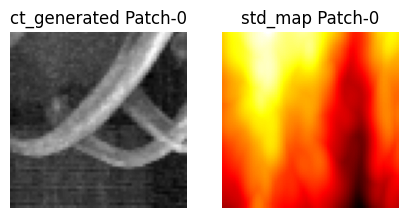

In [26]:
custom_dataset.plot_ct(500)

In [27]:
train_files, remaining_files = train_test_split(custom_dataset, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=42)

print(len(train_files), len(val_files), len(test_files))

Type of item: <class 'dict'>
Available keys: dict_keys(['ct_generated', 'std_map'])
Type of image data: <class 'numpy.ndarray'>
Shape of image data: (64, 64)
Shape of ct_generated: torch.Size([1, 64, 64])
Shape of std_map: torch.Size([1, 64, 64])
Type of item: <class 'dict'>
Available keys: dict_keys(['ct_generated', 'std_map'])
Type of image data: <class 'numpy.ndarray'>
Shape of image data: (64, 64)
Shape of ct_generated: torch.Size([1, 64, 64])
Shape of std_map: torch.Size([1, 64, 64])
Type of item: <class 'dict'>
Available keys: dict_keys(['ct_generated', 'std_map'])
Type of image data: <class 'numpy.ndarray'>
Shape of image data: (64, 64)
Shape of ct_generated: torch.Size([1, 64, 64])
Shape of std_map: torch.Size([1, 64, 64])
Type of item: <class 'dict'>
Available keys: dict_keys(['ct_generated', 'std_map'])
Type of image data: <class 'numpy.ndarray'>
Shape of image data: (64, 64)
Shape of ct_generated: torch.Size([1, 64, 64])
Shape of std_map: torch.Size([1, 64, 64])
Type of item

In [28]:
# transforms for data augmentation and refining

# train_transforms = transforms.Compose([
#     ScaleIntensityd(keys = ['ct_generated', 'std_map']), 
#     RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True), 
#     RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5), 
#     RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5) 
# ])

# val_transforms = transforms.Compose([
#     ScaleIntensityd(keys = ['ct_generated', 'std_map']) 
# ])

In [29]:
# transforms for data augmentation and refining

train_transforms = v2.Compose([v2.RandomHorizontalFlip(p=0.5),
                            v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(30),
                            v2.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
                            v2.ToDtype(torch.float32, scale=True),
                            #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            v2.Normalize(mean=[0.456], std=[0.224])
])

# val_transforms = v2.Compose([v2.RandomHorizontalFlip(p=0.5),
#                              v2.RandomVerticalFlip(p=0.5),
#                             v2.RandomRotation(30),
#                             v2.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
#                             v2.ToDtype(torch.float32, scale=True),
#                             #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#                             v2.Normalize(mean=[0.456], std=[0.224])
# ])

val_transforms = v2.Compose([
    v2.Resize((64,64)),  
    v2.ToTensor(), 
    v2.Normalize(mean=[0.456], std=[0.224]) 
])

/home/lchen122/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [30]:
# from monai.transforms import (
#     Compose, RandFlip, RandRotate, RandAffine,
#     ToTensor, NormalizeIntensity, EnsureChannelFirst, RandRotate90
# )

# train_transforms = Compose([
#     EnsureChannelFirst(),  
#     RandFlip(prob=0.5, spatial_axis=0),  
#     RandFlip(prob=0.5, spatial_axis=1), 
#     RandRotate90(prob=0.5, max_k=3), 
#     RandAffine(
#         prob=1.0, rotate_range=30, translate_range=(0.1, 0.1), 
#         scale_range=(0.8, 1.2), shear_range=10,
#         mode='bilinear'  
#     ),
#     ToTensor(),  
#     NormalizeIntensity(subtrahend=0.456, divisor=0.224)
# ])

# val_transforms = Compose([
#     EnsureChannelFirst(),
#     ToTensor(),
#     NormalizeIntensity(subtrahend=0.456, divisor=0.224)
# ])



In [31]:
# print( ct_generated.shape)
# ct_generated = train_transforms(ct_generated)
# print( ct_generated.shape)




## Section-4: Data Loader

In [32]:
## Complete your code here

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)



# for data in train_loader:
#     ct_generated = data['ct_generated']
#     std_map = data['std_map']

#     print("Batch shape of ct_gen:", ct_generated.shape)
#     print("Batch shape of std_map:", std_map.shape)
#     break

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, collate_fn=pad_list_data_collate)
for data in train_loader:
    ct_generated = data['ct_generated']
    std_map = data['std_map']
    # signal = data['signal']
    print(ct_generated.shape)
    print(std_map.shape)
    # print(signal.shape)
    break
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1, collate_fn=pad_list_data_collate)

Loading dataset:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 512/512 [00:00<00:00, 8478.49it/s]


torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


Loading dataset: 100%|██████████| 64/64 [00:00<00:00, 11481.41it/s]


## Section-5: UNet Training and Testing

In [33]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # self.conv_op = nn.Sequential(
        #     nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(out_channels),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(out_channels),
        #     nn.ReLU(inplace=True)
        # )

        
    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)
        
        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],1)
        
        return self.conv(x)   

In [34]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.down_convolution1 = DownSample(in_channels, 64)
        self.down_convolution2 = DownSample(64, 128)
        self.down_convolution3 = DownSample(128, 256)
        self.down_convolution4 = DownSample(256, 512)
        
        self.bottleneck = DoubleConv(512, 1024)
        
        self.up_convolution1 = UpSample(1024, 512)
        self.up_convolution2 = UpSample(512, 256)
        self.up_convolution3 = UpSample(256, 128)
        self.up_convolution4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        # self.out = nn.Sequential(
        #         nn.Conv2d(64, num_classes, 1),
        #         # nn.Sigmoid()
        #     )

        
    def forward(self, x):
        down1, p1 = self.down_convolution1(x)
        down2, p2 = self.down_convolution2(p1)
        down3, p3 = self.down_convolution3(p2)
        down4, p4 = self.down_convolution4(p3)
        
        b = self.bottleneck(p4)
        
        up1 = self.up_convolution1(b, down4)
        up2 = self.up_convolution2(up1, down3)
        up3 = self.up_convolution3(up2, down2)
        up4 = self.up_convolution4(up3, down1)
        
        out = self.out(up4)
        
        return out
        

In [35]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels = 1, num_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = './best'

In [36]:
# LOSS Function - Average Relative Error
def average_relative_error(output, target):
    # Avoid division by zero
    nonzero_mask = target != 0
    return torch.mean(torch.abs((output[nonzero_mask] - target[nonzero_mask]) / target[nonzero_mask]))

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Average Relative Error Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# test_output_2d = torch.rand(64, 64)
# test_target_2d = torch.rand(64, 64)
# error_2d_single = average_relative_error(test_output_2d, test_target_2d)
# print(type(error_2d_single))

In [37]:

def plot_comparison(ori, std, pred, epoch, save_path):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(ori, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(std, cmap='hot')
    axs[1].set_title('STD Image')
    axs[1].axis('off')
    
    axs[2].imshow(pred, cmap='hot')
    axs[2].set_title('Predicted STD')
    axs[2].axis('off')
    
    plt.show()
    if save_path:
        formatted_path = save_path.format(epoch=epoch)  
        fig.savefig(formatted_path, bbox_inches='tight', dpi=300)
        plt.close(fig)


  0%|          | 0/64 [00:00<?, ?it/s]

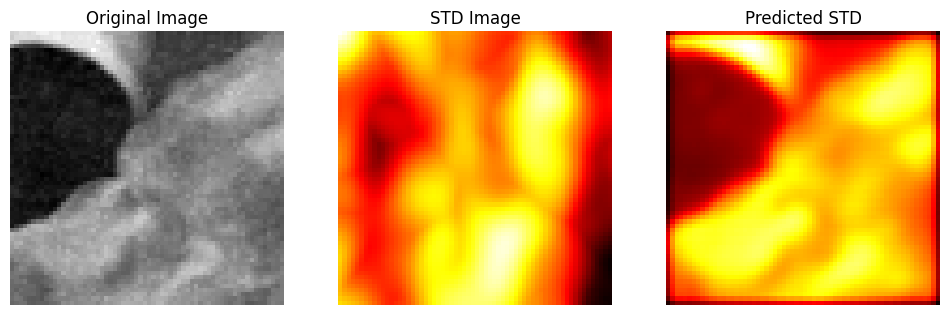

100%|██████████| 64/64 [00:01<00:00, 59.51it/s]


Epoch [1/20], Train Loss: 0.4676, Validation Loss: 0.3530


  0%|          | 0/64 [00:00<?, ?it/s]

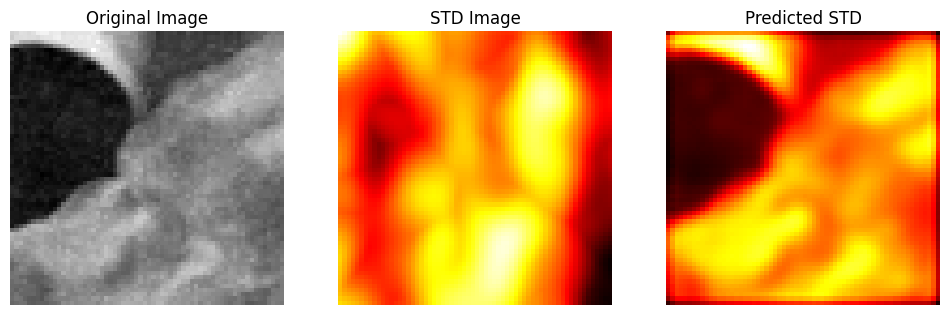

100%|██████████| 64/64 [00:01<00:00, 63.99it/s] 


Epoch [2/20], Train Loss: 0.4217, Validation Loss: 0.3376


  0%|          | 0/64 [00:00<?, ?it/s]

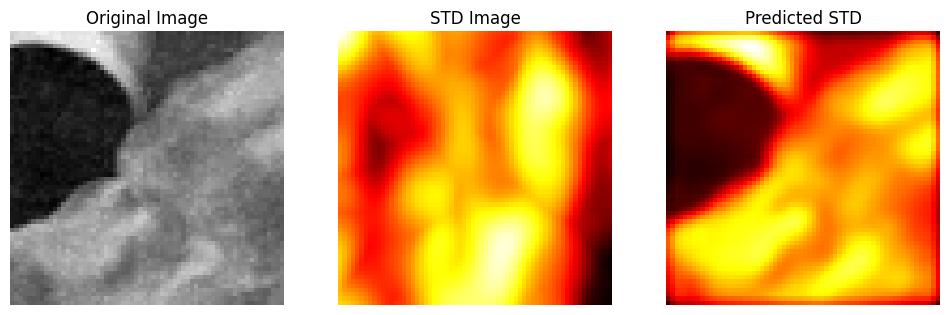

100%|██████████| 64/64 [00:01<00:00, 63.06it/s] 


Epoch [3/20], Train Loss: 0.4116, Validation Loss: 0.3244


  0%|          | 0/64 [00:00<?, ?it/s]

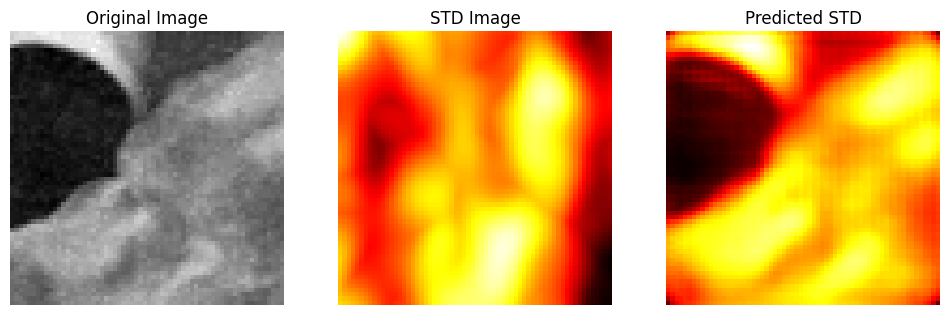

100%|██████████| 64/64 [00:01<00:00, 63.67it/s] 


Epoch [4/20], Train Loss: 0.4007, Validation Loss: 0.3438


  0%|          | 0/64 [00:00<?, ?it/s]

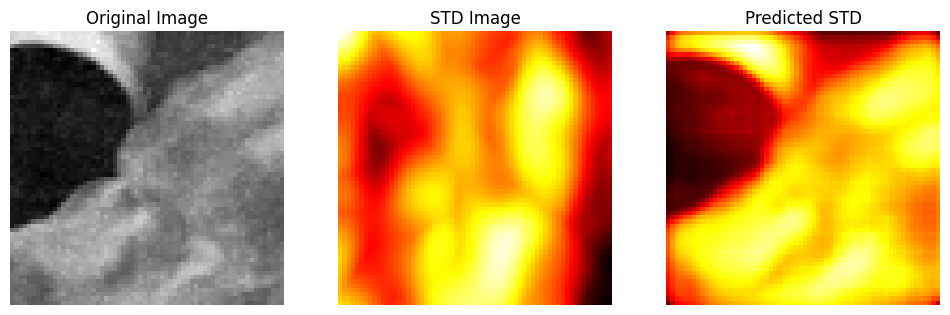

100%|██████████| 64/64 [00:01<00:00, 56.78it/s]


Epoch [5/20], Train Loss: 0.3947, Validation Loss: 0.3184


  0%|          | 0/64 [00:00<?, ?it/s]

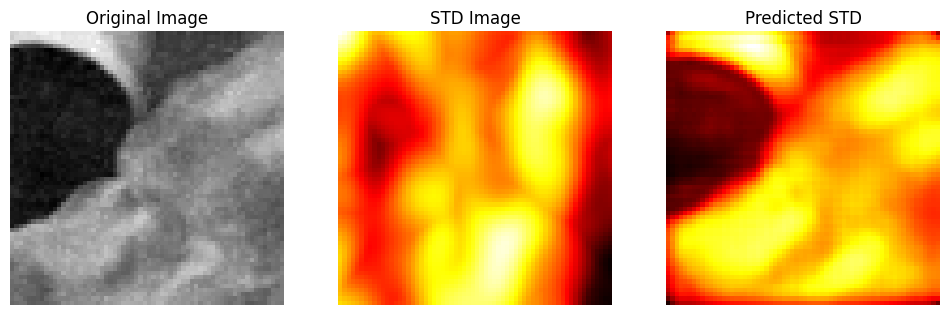

100%|██████████| 64/64 [00:01<00:00, 63.02it/s] 


Epoch [6/20], Train Loss: 0.4020, Validation Loss: 0.3145


  0%|          | 0/64 [00:00<?, ?it/s]

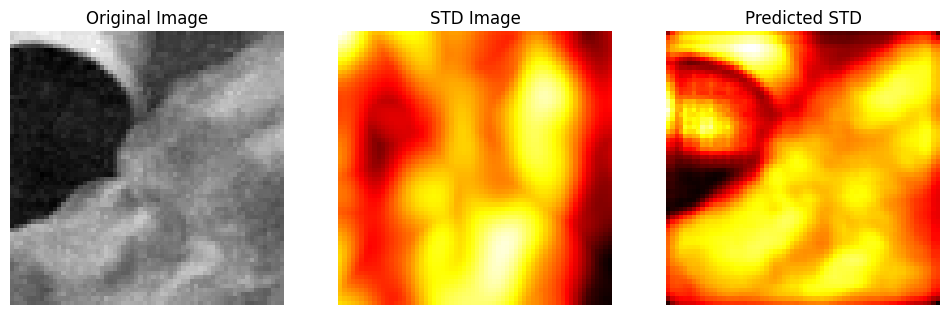

100%|██████████| 64/64 [00:00<00:00, 64.52it/s] 


Epoch [7/20], Train Loss: 0.3757, Validation Loss: 0.3130


  0%|          | 0/64 [00:00<?, ?it/s]

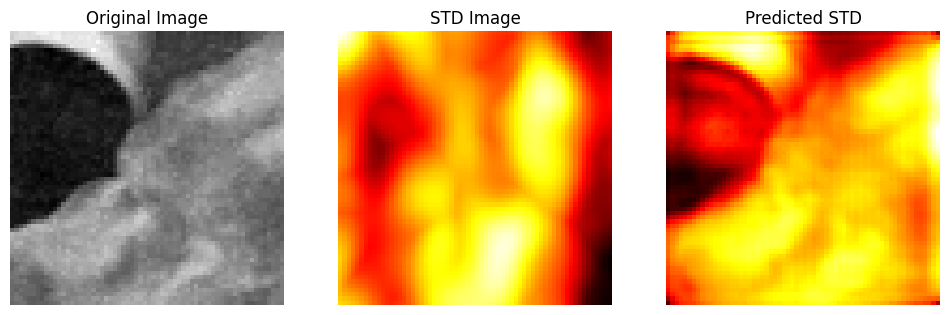

100%|██████████| 64/64 [00:01<00:00, 62.55it/s] 


Epoch [8/20], Train Loss: 0.3540, Validation Loss: 0.3326


  0%|          | 0/64 [00:00<?, ?it/s]

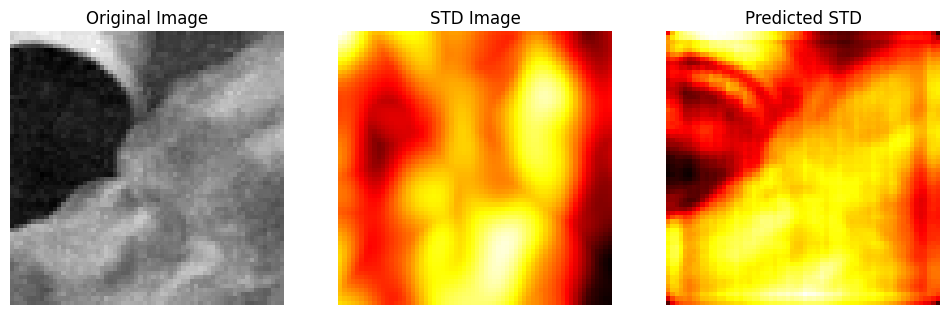

100%|██████████| 64/64 [00:04<00:00, 14.70it/s]


Epoch [9/20], Train Loss: 0.3621, Validation Loss: 0.3243


  0%|          | 0/64 [00:00<?, ?it/s]

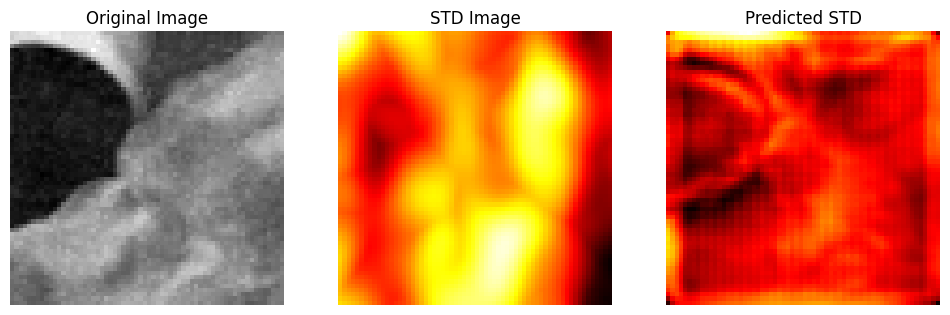

100%|██████████| 64/64 [00:01<00:00, 64.00it/s] 


Epoch [10/20], Train Loss: 0.3378, Validation Loss: 0.3167


  0%|          | 0/64 [00:00<?, ?it/s]

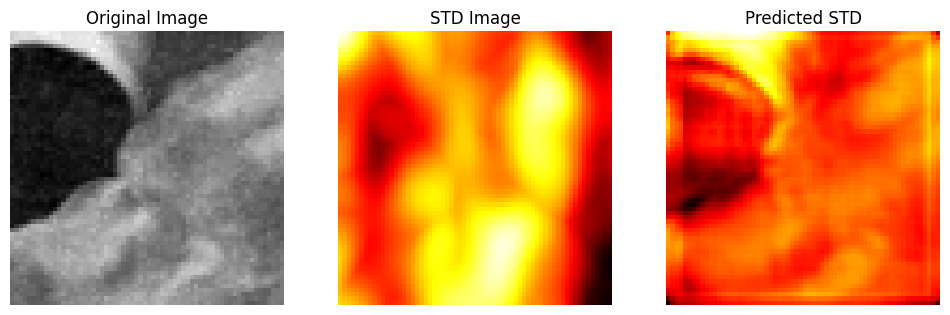

100%|██████████| 64/64 [00:01<00:00, 57.97it/s]


Epoch [11/20], Train Loss: 0.3338, Validation Loss: 0.3468


  0%|          | 0/64 [00:00<?, ?it/s]

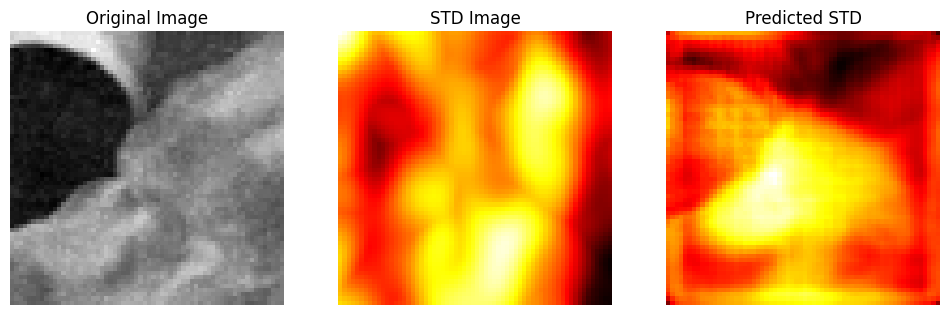

100%|██████████| 64/64 [00:01<00:00, 48.51it/s]


Epoch [12/20], Train Loss: 0.3125, Validation Loss: 0.3268


  0%|          | 0/64 [00:00<?, ?it/s]

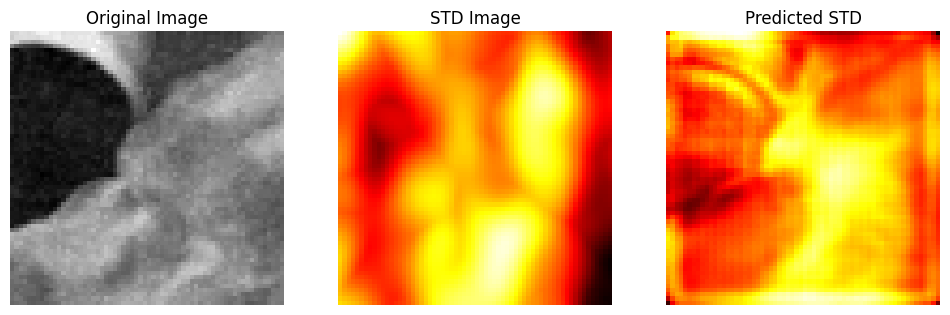

100%|██████████| 64/64 [00:01<00:00, 63.80it/s] 


Epoch [13/20], Train Loss: 0.3067, Validation Loss: 0.2993


  0%|          | 0/64 [00:00<?, ?it/s]

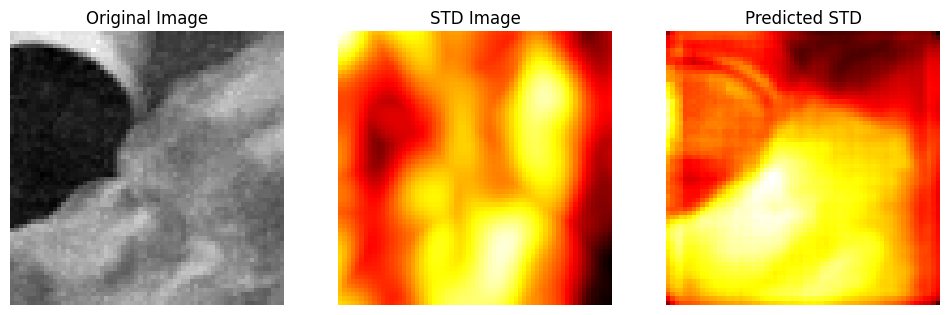

100%|██████████| 64/64 [00:01<00:00, 52.36it/s]


Epoch [14/20], Train Loss: 0.3078, Validation Loss: 0.3205


  0%|          | 0/64 [00:00<?, ?it/s]

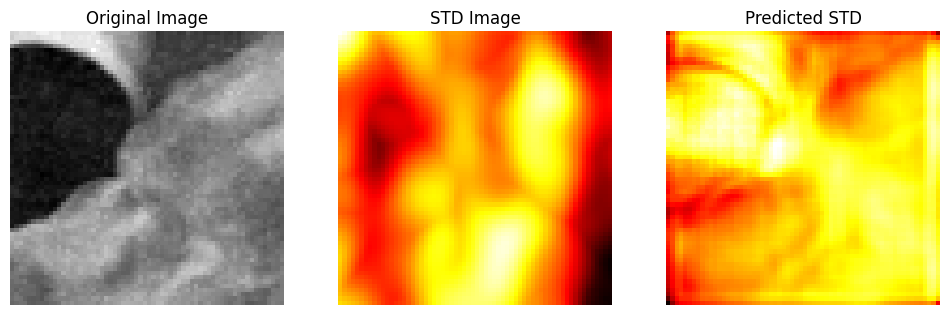

100%|██████████| 64/64 [00:01<00:00, 51.41it/s]


Epoch [15/20], Train Loss: 0.2977, Validation Loss: 0.3393


  0%|          | 0/64 [00:00<?, ?it/s]

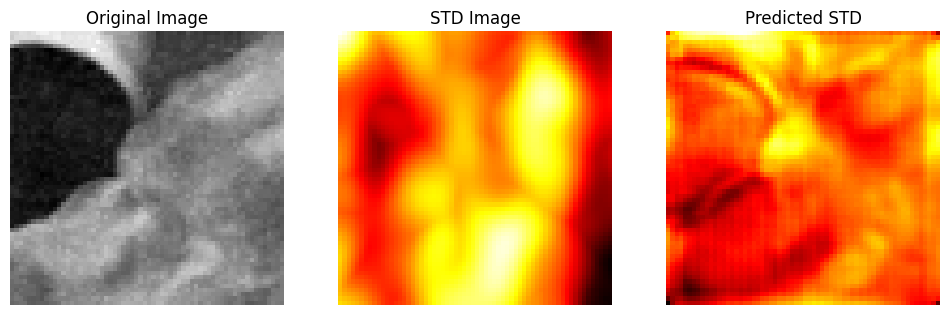

100%|██████████| 64/64 [00:01<00:00, 56.92it/s]


Epoch [16/20], Train Loss: 0.3008, Validation Loss: 0.3182


  0%|          | 0/64 [00:00<?, ?it/s]

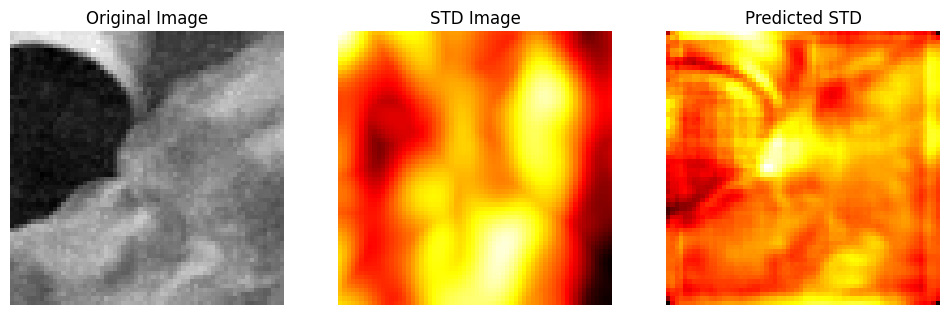

100%|██████████| 64/64 [00:01<00:00, 52.73it/s]


Epoch [17/20], Train Loss: 0.2981, Validation Loss: 0.2800


  0%|          | 0/64 [00:00<?, ?it/s]

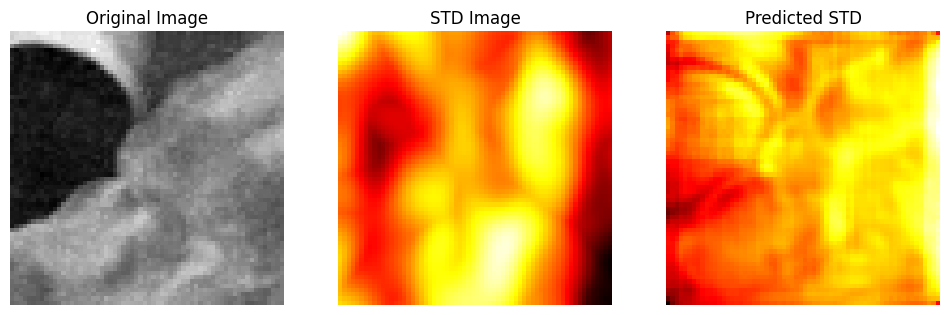

100%|██████████| 64/64 [00:01<00:00, 61.36it/s]


Epoch [18/20], Train Loss: 0.2922, Validation Loss: 0.2860


  0%|          | 0/64 [00:00<?, ?it/s]

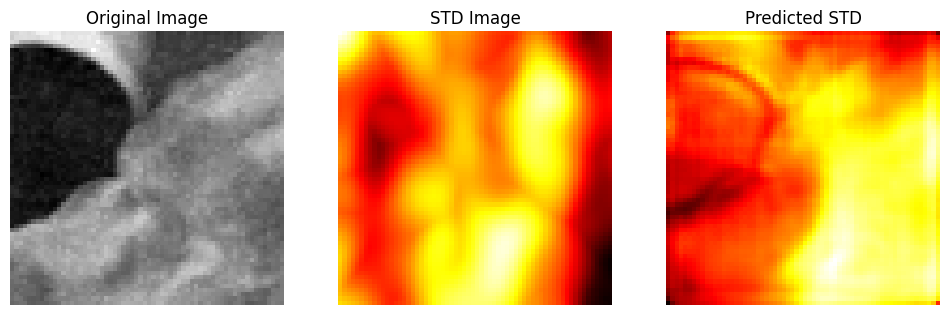

100%|██████████| 64/64 [00:01<00:00, 61.67it/s] 


Epoch [19/20], Train Loss: 0.2939, Validation Loss: 0.2993


  0%|          | 0/64 [00:00<?, ?it/s]

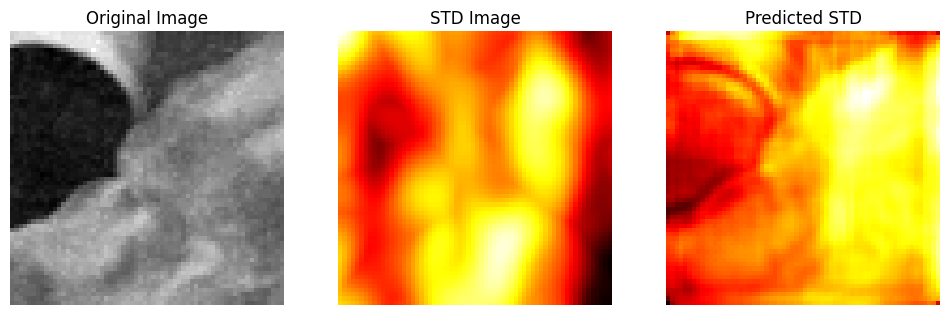

100%|██████████| 64/64 [00:01<00:00, 61.46it/s]


Epoch [20/20], Train Loss: 0.2833, Validation Loss: 0.2825


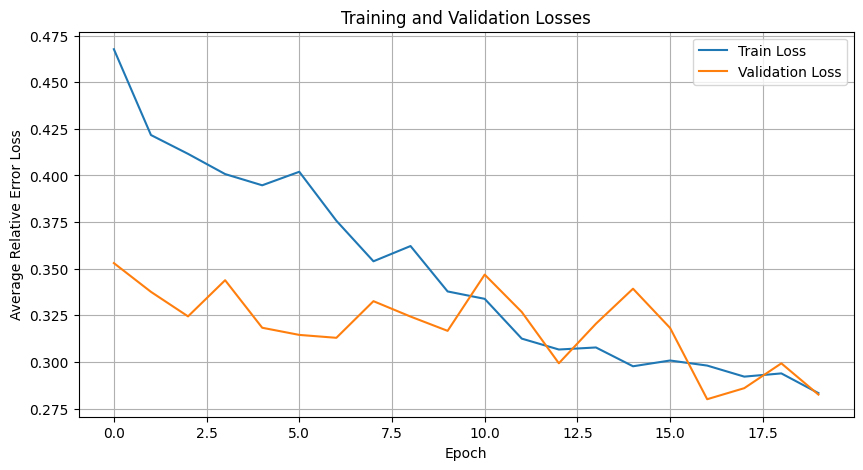

In [38]:
# training and validation

train_losses = []
val_losses = []
num_epochs = 20
best_loss = 1.0
import cv2

for epoch in range(num_epochs):

    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode
 
    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        
        optimizer.zero_grad()
        
        y_pred = model(img)
        
        loss = average_relative_error(y_pred, std_map)
        if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), 'best_model.pth')
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)

            val_loss = average_relative_error(y_pred, std_map)

            running_val_loss += val_loss.item() * img.size(0)

            if idx % 100 == 0:
                pred_np = y_pred.squeeze().cpu().numpy()
                img_np = img.squeeze().cpu().numpy()
                std_np = std_map.squeeze().cpu().numpy()
                plot_comparison(img_np, std_np, pred_np, epoch=epoch + 1, save_path="results/epoch_{epoch}.png")


        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
plot_losses(train_losses, val_losses)

## Section-6: RATUNet Training and Testing

In [39]:
class RatUNet(nn.Module):
    def __init__(self, block, num_features=64):
        super(RatUNet, self).__init__()
        self.inplanes = num_features
        
        self.conv = nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1, bias=True)

        self.layer1 = self._make_layer(block, 64, 128, 3, stride=2)
        self.layer2 = self._make_layer(block, 128, 256, 3, stride=2)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, 512, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

        self.layer4 = self._make_layer(block, 256, 256, 3)
        self.layer5 = self._make_layer(block, 128, 128, 3)
        self.layer6 = self._make_layer(block, 128, 128, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=True),
                                   nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
                                   nn.ReLU(inplace=True),
                                   )
        self.ca = SequentialPolarizedSelfAttention(128)
        self.lastconv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0.0, math.sqrt(1.0 / n))
                m.bias.data.zero_()

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        downsample = None
        self.inplanes = inplanes
        if stride != 1:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
                    nn.AvgPool2d(kernel_size=2, stride=stride),
            )
#        if  stride == 1 and self.inplanes == 2*planes:
#            downsample = nn.Sequential(
#                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
#                #nn.BatchNorm2d(planes)
#            )
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        res = self.conv(x)

        res2 = self.layer1(res)
        res3 = self.layer2(res2)        
        out = self.layer3(res3)
        
        out = self.deconv1(out)               
        out = self.layer4(out)
        out = torch.cat((out, res3), dim=1) 

        out = self.deconv2(out)        
        out = self.layer5(out)
        out = torch.cat((out, res2), dim=1)
        
        out = self.deconv3(out)        
        out = self.layer6(out)
        out = torch.cat((out, res), dim=1)
        
        out = self.conv2(out)
        out = self.ca(out)
        out = self.lastconv(out)
        
        return x - out


In [40]:
class BasicBlock(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=True)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.PReLU()#.LeakyReLU(0.2, inplace=True)# nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride = 1, padding=1, bias=True)
        #self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, stride = 1, padding=0, bias=True)

        self.downsample = downsample
        #self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)        
        
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual      
        out = self.relu(out)

        return out


In [41]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=True),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SequentialPolarizedSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.ch_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.ch_wq=nn.Conv2d(channel,1,kernel_size=(1,1))
        self.softmax_channel=nn.Softmax(1)
        self.softmax_spatial=nn.Softmax(-1)
        self.ch_wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))
        self.ln=nn.LayerNorm(channel)
        self.sigmoid=nn.Sigmoid()
        self.sp_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.sp_wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.agp=nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        b, c, h, w = x.size()

        #Channel-only Self-Attention
        channel_wv=self.ch_wv(x) #bs,c//2,h,w
        channel_wq=self.ch_wq(x) #bs,1,h,w
        channel_wv=channel_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        channel_wq=channel_wq.reshape(b,-1,1) #bs,h*w,1
        channel_wq=self.softmax_channel(channel_wq)
        channel_wz=torch.matmul(channel_wv,channel_wq).unsqueeze(-1) #bs,c//2,1,1
        channel_weight=self.sigmoid(self.ch_wz(channel_wz).reshape(b,c,1).permute(0,2,1)).permute(0,2,1).reshape(b,c,1,1) #bs,c,1,1self.ln(
        channel_out=channel_weight*x

        #Spatial-only Self-Attention
        spatial_wv=self.sp_wv(channel_out) #bs,c//2,h,w
        spatial_wq=self.sp_wq(channel_out) #bs,c//2,h,w
        spatial_wq=self.agp(spatial_wq) #bs,c//2,1,1
        spatial_wv=spatial_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        spatial_wq=spatial_wq.permute(0,2,3,1).reshape(b,1,c//2) #bs,1,c//2
        spatial_wq=self.softmax_spatial(spatial_wq)
        spatial_wz=torch.matmul(spatial_wq,spatial_wv) #bs,1,h*w
        spatial_weight=self.sigmoid(spatial_wz.reshape(b,1,h,w)) #bs,1,h,w
        spatial_out=spatial_weight*channel_out
        return spatial_out


In [42]:
# Model and optimizer initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RatUNet(BasicBlock, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model_saving_path = '/projectnb/ec500kb/projects/Project6/RatUNet.pth'

# Train the model
total_step = len(train_loader)
num_epochs = 300
best_val_loss = float('inf')  # Initialize best validation loss for model saving

In [43]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


100%|██████████| 64/64 [00:00<00:00, 66.27it/s]


Epoch [1/300], Train Loss: 0.5078, Validation Loss: 0.3472


100%|██████████| 64/64 [00:00<00:00, 69.92it/s]


Epoch [2/300], Train Loss: 0.4672, Validation Loss: 0.3204


100%|██████████| 64/64 [00:00<00:00, 73.03it/s]


Epoch [3/300], Train Loss: 0.4277, Validation Loss: 0.3191


100%|██████████| 64/64 [00:00<00:00, 74.76it/s]


Epoch [4/300], Train Loss: 0.4117, Validation Loss: 0.3080


100%|██████████| 64/64 [00:00<00:00, 71.10it/s]


Epoch [5/300], Train Loss: 0.4011, Validation Loss: 0.3069


100%|██████████| 64/64 [00:00<00:00, 68.93it/s]


Epoch [6/300], Train Loss: 0.4010, Validation Loss: 0.3255


100%|██████████| 64/64 [00:00<00:00, 79.05it/s]


Epoch [7/300], Train Loss: 0.3863, Validation Loss: 0.3010


100%|██████████| 64/64 [00:00<00:00, 72.99it/s]


Epoch [8/300], Train Loss: 4.2353, Validation Loss: 0.4130


100%|██████████| 64/64 [00:00<00:00, 75.88it/s]


Epoch [9/300], Train Loss: 65.6847, Validation Loss: 0.3933


100%|██████████| 64/64 [00:00<00:00, 78.40it/s]


Epoch [10/300], Train Loss: 0.4917, Validation Loss: 0.3315


100%|██████████| 64/64 [00:00<00:00, 76.93it/s]


Epoch [11/300], Train Loss: 0.4890, Validation Loss: 0.3319


100%|██████████| 64/64 [00:00<00:00, 75.87it/s]


Epoch [12/300], Train Loss: 0.4682, Validation Loss: 0.3245


100%|██████████| 64/64 [00:01<00:00, 34.63it/s]


Epoch [13/300], Train Loss: 0.4513, Validation Loss: 0.3143


100%|██████████| 64/64 [00:01<00:00, 63.11it/s]


Epoch [14/300], Train Loss: 0.4401, Validation Loss: 0.3132


100%|██████████| 64/64 [00:00<00:00, 76.91it/s]


Epoch [15/300], Train Loss: 0.4300, Validation Loss: 0.3147


100%|██████████| 64/64 [00:00<00:00, 77.22it/s]


Epoch [16/300], Train Loss: 0.4387, Validation Loss: 0.3207


100%|██████████| 64/64 [00:00<00:00, 74.64it/s]


Epoch [17/300], Train Loss: 0.4249, Validation Loss: 0.3138


100%|██████████| 64/64 [00:01<00:00, 35.42it/s]


Epoch [18/300], Train Loss: 0.4287, Validation Loss: 0.3138


100%|██████████| 64/64 [00:00<00:00, 73.48it/s]


Epoch [19/300], Train Loss: 0.4244, Validation Loss: 0.3290


100%|██████████| 64/64 [00:00<00:00, 77.95it/s]


Epoch [20/300], Train Loss: 0.4300, Validation Loss: 0.3106


100%|██████████| 64/64 [00:00<00:00, 69.26it/s]


Epoch [21/300], Train Loss: 0.4371, Validation Loss: 0.3869


100%|██████████| 64/64 [00:00<00:00, 78.32it/s]


Epoch [22/300], Train Loss: 1.1728, Validation Loss: 0.4130


100%|██████████| 64/64 [00:00<00:00, 79.98it/s]


Epoch [23/300], Train Loss: 0.5597, Validation Loss: 0.4126


100%|██████████| 64/64 [00:01<00:00, 40.70it/s]


Epoch [24/300], Train Loss: 0.5328, Validation Loss: 0.3900


100%|██████████| 64/64 [00:00<00:00, 78.23it/s]


Epoch [25/300], Train Loss: 0.4809, Validation Loss: 0.3352


100%|██████████| 64/64 [00:00<00:00, 72.28it/s]


Epoch [26/300], Train Loss: 0.4733, Validation Loss: 0.3445


100%|██████████| 64/64 [00:00<00:00, 81.21it/s]


Epoch [27/300], Train Loss: 0.4814, Validation Loss: 0.3266


 85%|████████▌ | 436/512 [00:18<00:03, 23.19it/s]

## Section-7: Uncertainty Estimation